In [1]:
#### ray tracing code for paper titled inhomogeneity-induced wavenumber diffusion ####

In [2]:
# import modules
import numpy as np
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.fft import fft2, ifft2
from scipy.integrate import odeint

In [3]:
def flow_interpolats(psik,xx,yy,kxx,kyy,deg=4):
    '''
    use inverse fft to find \psi(x,y) and derivatives
    output is interpolate functions \psi(x,y), \psi_x(x,y) etc.
    
    psik: array of Fourier transformed stream function
    xx,yy: real space coordinates
    kxx,kyy: horizontal and vertical wavenumber
    deg: degree of interpolate
    '''
    
    # padded x and y coords to feed into interpolator
    x_padd = np.zeros((xx.shape[1]+1))
    x_padd[1:] = xx[0,0:]
    y_padd = np.zeros((yy.shape[1]+1))
    y_padd[1:] = yy[0:,0]
    
    # empty array to append functions to
    intrps = []
    
    # below prefactors correspond to psi, psi_x, psi_y, psi_xx, psi_xy, psi_yy
    prefs = 1, 1j*kxx, 1j*kyy, -kxx**2, -kxx*kyy, -kyy**2
    
    # length of psi
    N = np.shape(psik)[0]
    
    for i in range(6):
        # psi, psi_x, psi_y etc.
        qr = np.real(ifft2(prefs[i]*psik)*(N**2))
        
        # padded array to fill with qr
        Q_padd = np.zeros((qr.shape[0]+1,qr.shape[1]+1))
        Q_padd[0:-1,0:-1] = qr
        Q_padd[-1,:] = Q_padd[0,:]
        Q_padd[:,-1] = Q_padd[:,0]
        
        # interpolate over xx, yy
        intrps.append(RectBivariateSpline(y_padd, x_padd, Q_padd, kx=deg, ky=deg))

    return intrps

In [4]:
def xdot_kdot_winterp(xykl, t, interps, Ro, Bu, L):
    '''
    ray equations for just Doppler effect
    
    the non-dimensionalisation used here differs to the scheme in the paper
    in particular, Ro and Bu below are not the actual Ro and Bu numbers of the flow
    
    xykl: vector of x, y, k, l coordinates
    t: time, not used but required for odeint
    interps: output of flow_interpolats
    Ro, Bu: assigned Rossby and Burger numbers. !!!IMPORTANT!!! these are not the actual Rossby and Burger...
            ...numbers of the flow. Ro rescales the time coordinate and flow strength and Bu changes L_D, ...
            ...the Rossby radius of deformation. The actual Rossby and Burger number must be found from the flow
    L: length of LXL domain
    '''
    # unpack the variables
    x, y, k, l = xykl
    # push the flow back into the domain considering period boundary condition
    x_in = x - np.floor(x/L)*(L)
    y_in = y - np.floor(y/L)*(L)
    
    # intrinsic freq. (times Rossby number)
    w0Ro = np.sqrt(1 + Bu*(k**2 + l**2))
    
    # eval. flow
    psis = []
    for i in range(6):
        psis.append(interps[i].ev(np.ravel(y_in), np.ravel(x_in)))
    psi, psix, psiy, psixx, psixy, psiyy = psis
    
    # ray eqns
    dxdt = float(Bu*k/w0Ro/Ro - psiy)
    dydt = float(Bu*l/w0Ro/Ro + psix)     
    dkdt = float(k*psixy - l*psixx)
    dldt = float(k*psiyy - l*psixy)
    RHS = [dxdt, dydt, dkdt, dldt]
    return RHS

In [5]:
def xdot_kdot_height(xykl, t, interps, Ro, Bu, L):
    '''
    ray equations for just height fluctuations
    
    see xdot_kdot_winterp for variable definitions
    '''
    # unpack the variables
    x, y, k, l = xykl
    # push the flow back into the domain considering period boundary condition
    x_in = x - np.floor(x/L)*(L)
    y_in = y - np.floor(y/L)*(L)
    
    # intrinsic freq. (times Rossby number)
    w0Ro = np.sqrt(1 + Bu*(k**2 + l**2))
    
    # eval. flow
    psis = []
    for i in range(6):
        psis.append(interps[i].ev(np.ravel(y_in), np.ravel(x_in)))
    psi, psix, psiy, psixx, psixy, psiyy = psis
    
    kh2 = k**2 + l**2
    pref = (2 + Bu*kh2)*psi/2/(w0Ro**3)
    
    # ray eqns
    dxdt = float(Bu*k/w0Ro/Ro + pref*k)
    dydt = float(Bu*l/w0Ro/Ro + pref*l)     
    dkdt = float(-kh2/2/w0Ro*psix)
    dldt = float(-kh2/2/w0Ro*psiy)
    RHS = [dxdt, dydt, dkdt, dldt]
    return RHS

In [6]:
def xdot_kdot_tot(xykl, t, interps, Ro, Bu, L):
    '''
    ray equations for both effects fluctuations
    
    see xdot_kdot_winterp for variable definitions
    '''
    # unpack the variables
    x, y, k, l = xykl
    # push the flow back into the domain considering period boundary condition
    x_in = x - np.floor(x/L)*(L)
    y_in = y - np.floor(y/L)*(L)
    
    # intrinsic freq. (times Rossby number)
    kh2 = k**2 + l**2
    w0Ro = np.sqrt(1 + Bu*kh2)
    
    # eval. flow
    psis = []
    for i in range(6):
        psis.append(interps[i].ev(np.ravel(y_in), np.ravel(x_in)))
    psi, psix, psiy, psixx, psixy, psiyy = psis
    
    pref = (2 + Bu*kh2)*psi/2/(w0Ro**3)
    
    # ray eqns
    dxdt = float(Bu*k/w0Ro/Ro - psiy + pref*k)
    dydt = float(Bu*l/w0Ro/Ro + psix + pref*l)     
    dkdt = float(k*psixy - l*psixx -kh2/2/w0Ro*psix)
    dldt = float(k*psiyy - l*psixy -kh2/2/w0Ro*psiy)
    RHS = [dxdt, dydt, dkdt, dldt]
    return RHS

In [7]:
def cosbetween(vx1, vy1, vx2, vy2):
    '''
    cos theta between vectors v1 = (vx1, vy1) and v2 = (vx2, vy2)
    
    for use in ensemble average of ray angles
    '''
    vdotv = vx1*vx2 + vy1*vy2
    vxv = np.sqrt(vx1**2 + vy1**2)*np.sqrt(vx2**2 + vy2**2)
    costheta = vdotv/vxv
    
    # remove numerical error
    index = np.where(costheta>1)
    costheta[index] = 1
    index = np.where(costheta<-1)
    costheta[index] = -1

    return costheta

In [8]:
def gridpoints(filename):
    '''
    reads file of form flow.mat and outputs cartesian physical space and wavevector space coordinates
    '''

    kxyxy = []
    for string in ['kxx', 'kyy', 'xx', 'yy']:
        kxyxy.append(sio.loadmat(filename)[string])
    kxx, kyy, xx, yy = kxyxy
    
    # turn wavevector into floats
    kxx, kyy = np.array(kxx, dtype=float), np.array(kyy, dtype=float)
    
    return kxx, kyy, xx, yy

def flow(filename, kxx, kyy, xx, yy):
    '''
    take file of form flow.mat and return interpolants of normalised stream function
    '''
    
    # ensure real
    psik_ = sio.loadmat(filename)['psik']
    psi = ifft2(psik_)
    psi_ = np.real(psi)
    psik = fft2(psi_)

    # normalise
    Urms = np.sqrt(np.sum(((kxx**2 + kyy**2)*(np.absolute(psik)**2))))
    psik /= Urms

    # generate interpolants
    interps = flow_interpolats(psik,xx,yy,kxx,kyy)
    
    return interps

def seeds(L, rtN):
    '''
    for domain of length L, distributes rtN^2 rays evenly in (x,y) space with a random angle
    
    outputs x coords, y coords and angles
    '''
    
    # x seeds
    dx = L/rtN
    x_ = np.arange(rtN)*dx
    y_ = np.copy(x_)
    x_seeds_, y_seeds_ = np.meshgrid(x_, y_)
    x_seeds, y_seeds = np.reshape(x_seeds_, rtN**2), np.reshape(y_seeds_, rtN**2)
    
    # angles
    angles = np.linspace(-np.pi, np.pi, rtN**2)
    np.random.shuffle(angles)
    
    return x_seeds, y_seeds, angles

In [9]:
def ray_tracing(filename, rtN, Bu, Ro, k=100, t_end=.5, L=2*np.pi, Nt=4001):
    '''
    ray tracing with variables and functions defined above
    
    new variables:
    -> k is wavenumber rays are intialised with relative to domain size
    -> output across t_vec, a time vector starting at 0 and ending at t_end with Nt intervals
    
    !!!please note comment on Bu, Ro in function description for xdot_kdot_winterp before use!!!
    '''
    
    # gridpoints and flow interpolants
    kxx, kyy, xx, yy = gridpoints(filename)
    interps = flow(filename, kxx, kyy, xx, yy)
    
    # generate starting x,y,angle
    x_seeds, y_seeds, angles = seeds(L, rtN)
    
    # array to save to
    xykl_arrays =np.zeros([3,rtN**2, 4,Nt+1])
    costheta_array = np.zeros([3, rtN**2, Nt+1])
    
    t_vec = np.linspace(0, t_end, Nt+1)

    # ray tracing
    for label in ['Doppler', 'Height', 'Both']:
        for j in range(rtN**2):

            # intial k, l
            angle = angles[j]
            k_seed, l_seed = k*np.cos(angle), k*np.sin(angle)
            
            # intial xykl vector
            xykl0 = np.array([x_seeds[j],y_seeds[j],k_seed,l_seed])
            
            # ray trace for each term, then both together
            if label == 'Doppler':
                xykls = odeint(xdot_kdot_winterp, xykl0, t_vec, args=(interps, Ro, Bu, L))
            elif label == 'Height':
                xykls = odeint(xdot_kdot_height, xykl0, t_vec, args=(interps, Ro, Bu, L))
            else:
                xykls = odeint(xdot_kdot_tot, xykl0, t_vec, args=(interps, Ro, Bu, L))
            
            # make sure output doesn't run outside LXL box
            xray = xykls[:, 0] - np.floor(xykls[:, 0]/L)*(L)
            yray = xykls[:, 1] - np.floor(xykls[:, 1]/L)*(L)
            kray = xykls[:, 2] 
            lray = xykls[:, 3]

            # index determines which row of xykl_arrays output is saved to
            if label == 'Doppler':
                index = 0
            elif label == 'Height':
                index = 1
            else:
                index = 2
            
            # output in single array
            xykl_arrays[index,j,0,:] = xray
            xykl_arrays[index,j,1,:] = yray
            xykl_arrays[index,j,2,:] = kray
            xykl_arrays[index,j,3,:] = lray
            
            
            # this code only works if ray is not deflected to the point that it reverses
            # error message here indicates if this has occurred
            costheta = cosbetween(kray, lray, k_seed, l_seed)
            theta = np.arccos(costheta)
            if len(np.where(theta - np.pi +  np.pi/10 > 0)[0]) != 0:
                print('INVALID RAY')
        
            # array of costheta, with theta the angle of deflection for each ray
            costheta_array[index,j] = costheta
            
    return t_vec, xykl_arrays, costheta_array

In [10]:
#### example ray tracing using flow in file flow.mat ####
#### as stated before, Bu and Ro are not the actual Burger and Rossby number... ####
#### ... and changing them amounts to varying L_D and rescaling the time coord ####
#### ... and changing the flow strength

filename = 'flow.mat'
rtN = 10

# ray trace
t_vec, xykl_arrays, costheta_array = ray_tracing(filename, rtN, 0.045, 0.01)

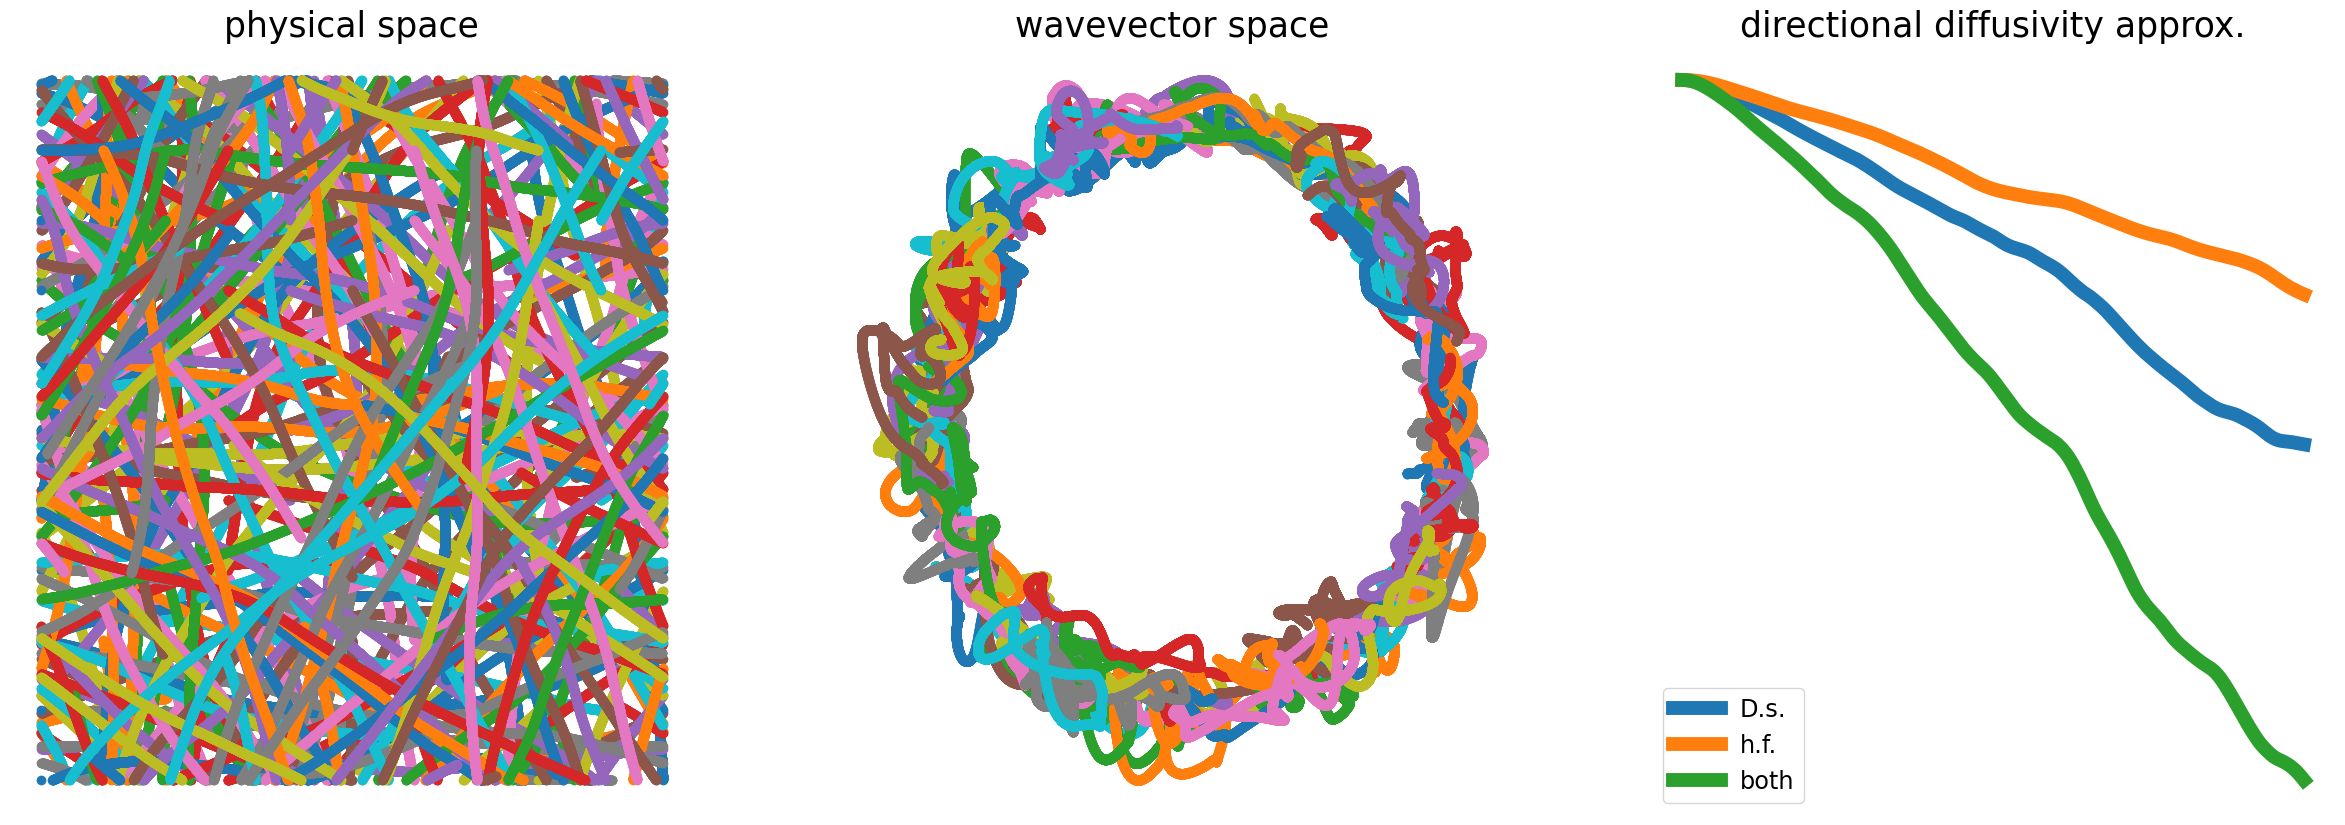

In [11]:
#### plots of above
fig, axs = plt.subplots(1,3,figsize=[30,10])


# plotting only ray tracing with both in x and k space
for ray in xykl_arrays[2]:
    axs[0].plot(ray[0], ray[1],'o')
    axs[1].plot(ray[2], ray[3],'o')

# plotting all 3 cosine ensemble averages
labels = ['D.s.','h.f.','both']
for i in range(len(labels)):
    cos = np.mean(costheta_array[i], axis=0)
    logcos = np.log(cos/cos[0])
    axs[2].plot(t_vec, logcos, label=labels[i],linewidth=10)


titles = ['physical space', 'wavevector space', 'directional diffusivity approx.']
for j in range(len(axs)):
    ax = axs[j]
    ax.axis('off')
    ax.set_title(titles[j],fontsize=25)
    
axs[2].legend(fontsize='xx-large',loc=3)

plt.show()